# Imports

In [131]:
import json
import math
import random
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
from pprint import pprint
from typing import List, Tuple, Dict, Union
from functools import partial

%matplotlib inline

# Loss function

## Airplanes bounding boxes

In [6]:
# загрузим json с размеченными bounding boxes
with open("./data/airplanes.json", "r") as json_file:
    json_data = json.load(json_file)
json_data

[{'id': 1,
  'annotations': [{'id': 1,
    'completed_by': 1,
    'result': [{'original_width': 891,
      'original_height': 594,
      'image_rotation': 0,
      'value': {'x': 4.040404040404041,
       'y': 29.653679653679653,
       'width': 18.037518037518037,
       'height': 12.121212121212121,
       'rotation': 0,
       'rectanglelabels': ['Airplane']},
      'id': 'EGZ3Pu3c29',
      'from_name': 'label',
      'to_name': 'image',
      'type': 'rectanglelabels',
      'origin': 'manual'},
     {'original_width': 891,
      'original_height': 594,
      'image_rotation': 0,
      'value': {'x': 7.792207792207792,
       'y': 41.55844155844156,
       'width': 64.21356421356421,
       'height': 29.87012987012987,
       'rotation': 0,
       'rectanglelabels': ['Airplane']},
      'id': 'vKLOXblBcm',
      'from_name': 'label',
      'to_name': 'image',
      'type': 'rectanglelabels',
      'origin': 'manual'},
     {'original_width': 891,
      'original_height': 594,
    

К кеаждому bounding box имеется аннотация, состоящая из параметров:
- height - высота bounding box, указанная в процентах от размера изображения (что очень удобно, т.к. мы не привязаны к размеру изображения), [0, 100]
- width - ширина bounding box, также указана в процентах, [0, 100]
- x и y - коородинаты левого верхнего угла bounding box, указаны в процентах, [0, 100]
- и т.д.

Спарсим аннотации, при этом
- округлим полученные значения до целого вверх
- заменим координаты левого верхнего угла координатами центра

In [85]:
def prepare_annotations(annotation: dict, use_center: bool = True, r: bool = False) -> Tuple[Union[int, float]]:
    """
    Функция препроцессинга аннотации. На вход принимает аннотацию из разметки (с относительными 
    значениями ширины, высоты, относительными координатами левого верхнего угла bounding box), 
    а на выход tuple - набор значений, описывающих bounding box:
    - абсолютную координату X левого верхнего угла (или центра) bounding box
    - абсолютную координату Y левого верхнего угла (или центра) bounding box
    - абсолютное значение ширины bounding box
    - абсолютное значение высоты bounding box
    Также функция округляет полученные значения до целых, если стоит параметр r = True.

    :param annotaton: аннотация
    :param use_center: если необходимо сменить координаты с левого верхнего угла на центр
    :param r: если необходимо округлить все значения bounding box до целых
    """
    img_width, img_height = annotation["image_width"], annotation["image_height"]
    x, y = img_width*annotation["x"]/100, img_height*annotation["y"]/100
    w, h = img_width*annotation["width"]/100, img_height*annotation["height"]/100

    # изменить на координаты центра bounding box
    if use_center:
        x += w/2
        y += h/2
    values = (x, y, w, h)

    # округление значений до целых
    if r:
        values = tuple(map(round, values))
    return values


# извлечем аннотации
annotations = \
    [{
        **annotation.get("value"), 
        "image_height": annotation.get("original_height"), 
        "image_width": annotation.get("original_width")
    } for annotation in json_data[0].get("annotations")[0].get("result")]
annotations = \
    [prepare_annotations(annotation=annotation, use_center=True, r=True) for annotation in annotations]
print("Общее количество аннотаций/bounding boxes", len(annotations))
pprint(annotations[0])

Общее количество аннотаций/bounding boxes 10
(116, 212, 161, 72)


In [149]:
def prepare_predictions(annotation: Tuple[int], image_size: Tuple[int, int], percentage: Tuple[float], 
                        r: bool = False, seed: int = None) -> Tuple[Union[int, float]]:
    """
    Функция принимает параметры bounding box, а именно:
    - абсолютную координату X левого верхнего угла (или центра) bounding
    - абсолютную координату Y левого верхнего угла (или центра) bounding
    - абсолютное значение ширины bounding box
    - абсолютное значение высоты bounding box
    И меняет эти значения в соответствии с percentage.

    :param annotation: Tuple с параметрами bounding box
    :param image_size:
    :param percentage:
    :param r: если необходимо округлить все значения bounding box до целых
    :param seed:
    """
    if random is not None:
        random.seed(seed)
        
    img_w, img_h = image_size

    # deviations
    x_dev, y_dev = percentage[0]*image_size[0], percentage[1]*image_size[1]
    w_dev, h_dev = percentage[2]*image_size[0], percentage[3]*image_size[1],

    # calculate values
    x = annotation[0] + random.uniform(-x_dev, x_dev)
    y = annotation[1] + random.uniform(-y_dev, y_dev)
    w = annotation[2] + random.uniform(-w_dev, w_dev)
    h = annotation[3] + random.uniform(-h_dev, h_dev)
    values = (x, y, w, h)

    # округление значений до целых
    if r:
        values = tuple(map(round, values))
    return values


ppfunc_partial = partial(prepare_predictions, image_size=(891, 594), percentage=(0.1, 0.1, 0.1, 0.1), r=True)
predictions = [ppfunc_partial(annotation) for annotation in annotations]

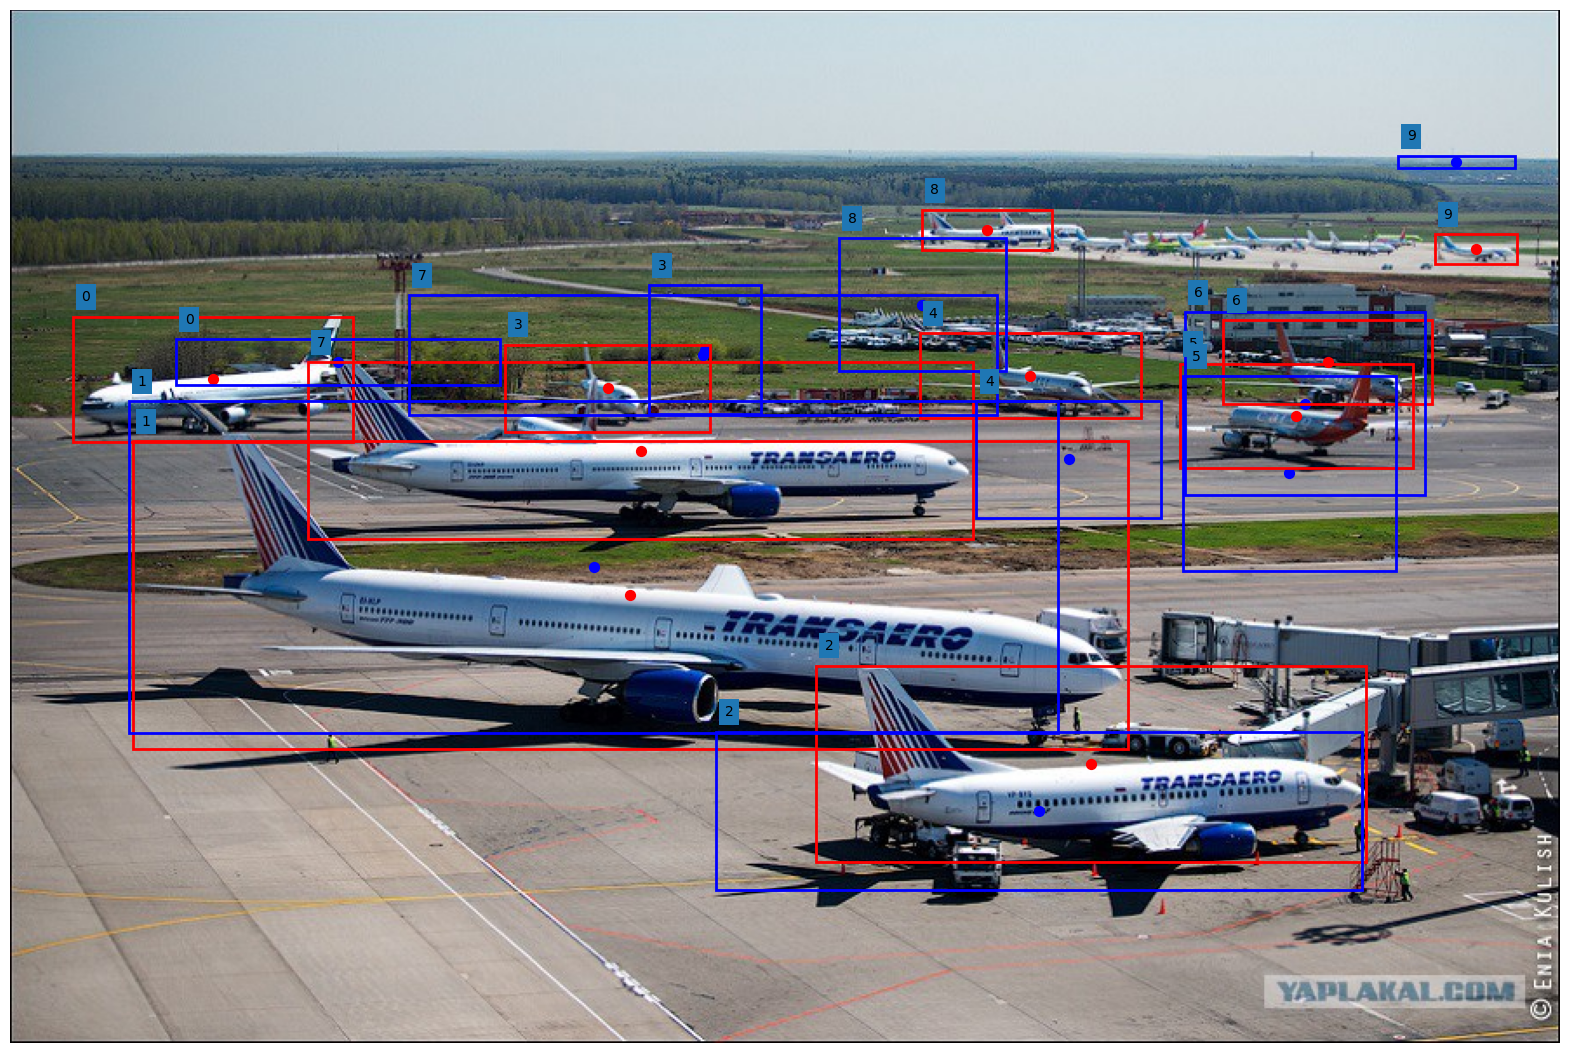

In [150]:
def plot_bboxes(ax, bboxes: Tuple[Union[int, float]], c: str = "red", lw: int = 1) -> None:
    for idx, (x, y, w, h) in enumerate(bboxes):
        # plot bounding boxes
        rect = patches.Rectangle((x - w/2, y - h/2), w, h, linewidth=lw, edgecolor=c, facecolor='none')
        ax.add_patch(rect)

        # plot anchor point
        ax.scatter(x=x, y=y, c=c, marker="o", s=50)
        
        # plot numbers
        ax.text(x - w/2 + 5, y - h/2 - 9, s=f"{idx}", bbox=dict(fill=True, edgecolor="white", linewidth=0))
    return


img = Image.open("./data/airplanes.jpg")
fig, ax = plt.subplots(figsize=(20, 20))
ax.imshow(img)
plot_bboxes(ax=ax, bboxes=annotations, lw=2)
plot_bboxes(ax=ax, bboxes=predictions, c="blue", lw=2)
ax.axis("off");